In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time

In [2]:
from modules import mfnet, locnet, baselinenet
from modules import retina

In [3]:
device = torch.device("cuda:0")

torch.cuda.is_available()

True

In [4]:
torch.manual_seed(78945)
np.random.seed(78945)

In [5]:
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def readImg(path):
    
    I = cv2.imread(path)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = I[:256, :256, :]
    I = np.transpose(I, (-1, 0, 1))/127.5-1
    
    return I

def dataloader(path, batch_size = 32):
    y = []
   
    random_list = np.random.randint(1, 33, size=batch_size)

    for i in random_list:
        try:
            yy = readImg(os.path.join(path, "{:05d}_0.jpeg".format(i)))
        except:
            print("errneous idx: ", i)
        y.append(torch.Tensor(yy))

    y = torch.stack(y)
    return y

In [7]:
class roboticsnet(nn.Module):
    
    def __init__(self):
        super(roboticsnet, self).__init__()
        self._retina = retina()
        self._mfnet = mfnet()
        self._locnet = locnet()
        self._baselinenet = baselinenet()
        
    def forward(self, x, J_prev):
        

        X2 = J_prev
        mu,l = self._locnet(J_prev)
        X1 = self._retina.foveate(x, l, isIt = True)
        J = self._mfnet(X1, X2)

        b = self._baselinenet(J).squeeze()
        log_pi = torch.distributions.Normal(mu, 0.1).log_prob(l)
        log_pi = torch.sum(log_pi, dim=1)
        
        return J, l, b, log_pi

In [8]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [9]:
model = roboticsnet()

In [10]:
checkpoint = torch.load("../ckpt/model_ckpt.pth")

model._mfnet.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)
dfs_freeze(model._mfnet)

In [12]:
print(model)
print(get_parameter_number(model))

roboticsnet(
  (_mfnet): mfnet(
    (_encoder): encoder(
      (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    )
    (_decoder): decoder(
      (deconv4): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(4, 4))
      (deconv5): ConvTranspose2d(64, 16, kernel_size=(4, 4), stride=(4, 4))
      (conv6): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (_locnet): locnet(
    (_posnet): posnet(
      (conv7): Conv2d(3, 16, kernel_size=(4, 4), stride=(4, 4))
      (conv8): Conv2d(16, 64, kernel_size=(4, 4), stride=(4, 4))
      (conv9): Conv2d(64, 128, kernel_size=(4, 4), stride=(4, 4))
    )
    (fc1): Linear(in_features=2048, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=2, bias=True)
  )
  (_baselinenet): baselinenet(
    (_posnet): posnet

In [13]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [14]:
def train_one_epoch(y, J_prev):
   
    baselines = []
    log_pi = []
    model.train()
    optimizer.zero_grad()
    
    J = J_prev
    for i in range(1):
        J, l, b, p = model(y, J)
        baselines.append(b)
        log_pi.append(p)
    
    baselines = torch.stack(baselines).transpose(1, 0)
    log_pi = torch.stack(log_pi).transpose(1, 0)
    
    R = -torch.mean((J - y)**2, [1, 2, 3])
    R = 100 * R.unsqueeze(1).repeat(1, 1)

#    loss_baseline = F.mse_loss(baselines, R)
    adjusted_reward = R# - baselines.detach()

    loss_reinforce = torch.sum(-log_pi*adjusted_reward, dim=1)
    loss_reinforce = torch.mean(loss_reinforce, dim=0)
    loss = loss_reinforce#+loss_baseline
    loss.backward()

    optimizer.step()
    print("loss_rl: {:.6f}".format(loss_reinforce.item()))
    return J

In [15]:
batch_size = 5
y = dataloader('../../datasets/highres_dataset2/', batch_size=batch_size)
foveate_fun = retina().foveate
l_J = torch.rand(batch_size, 2)*2-1
J_prev = foveate_fun(y, l_J, isIt = False)

In [16]:
def display(imageTensor):
    if device != 'cpu':
        imageTensor = imageTensor.cpu()
    
    imgNum = imageTensor.size()[0]
    
    fig, ax = plt.subplots(1, imgNum, figsize=(16, 8))
    for i in range(imgNum):
        ax[i].imshow(imageTensor[i].numpy().transpose(1, 2, 0)/2+0.5)
    plt.show()

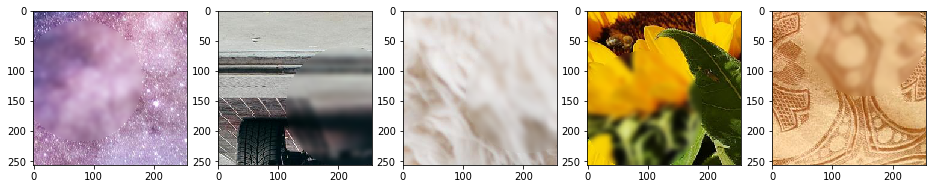

In [17]:
display(J_prev[:5])

In [18]:
for i in range(10):
    J = train_one_epoch(y, J_prev)

loss_rl: 1.179772
loss_rl: 1.514331
loss_rl: 1.569120
loss_rl: 1.788964
loss_rl: 1.664325
loss_rl: 2.016991
loss_rl: 1.856106
loss_rl: 0.299058
loss_rl: 0.382052
loss_rl: 2.065123


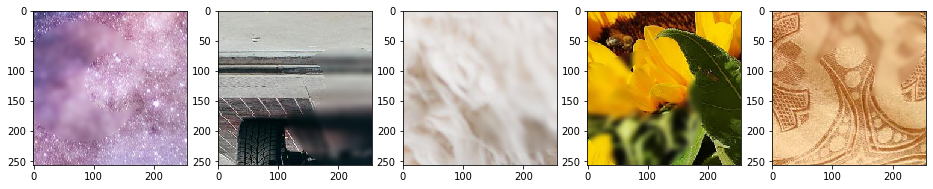

In [19]:
display(J[:5])